This example illustrates fitting and comparing several Machine Learning algorithms for classifying the binary target in the         
big_organics data set.

The steps include:                              
                                                                      
1. PREPARE AND EXPLORE  
  a) Check data is loaded into CAS                               
<br>                                                                      
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model using a Random Forest  
  b) Fit a model using Gradient Boosting  
  c) Fit a model using a Neural Network  
  d) Fit a model using a Support Vector Machine                       
<br>                                                                      
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts                                  

### Import packages

In [1]:
from swat import *
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
from swat.render import render_html
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### CAS Server connection details

In [2]:
cashost='eeclxvm128b.unx.sas.com'
casport=5570
casauth='~/.authinfo'
indata_dir="/home/sasdemo/data"
indata="big_organics"

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo="~/.authinfo", caslib="casuser")
sess

CAS('eeclxvm128b.unx.sas.com', 5570, 'sasdemo', protocol='cas', name='py-session-1', session='8f460342-6191-b848-a07a-9f0fc8bd6bd0')

### Import action sets

In [4]:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.


[actionset]

 'dataStep'

+ Elapsed: 0.00114s, user: 0.001s, mem: 0.0448mb

NOTE: Added action set 'dataPreprocess'.


[actionset]

 'dataPreprocess'

+ Elapsed: 0.000138s, mem: 0.0156mb

NOTE: Added action set 'cardinality'.


[actionset]

 'cardinality'

+ Elapsed: 0.000581s, mem: 0.0304mb

NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.0016s, user: 0.002s, mem: 0.0345mb

NOTE: Added action set 'regression'.


[actionset]

 'regression'

+ Elapsed: 0.00141s, user: 0.001s, mem: 0.0334mb

NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.0175s, sys: 0.001s, mem: 0.0293mb

NOTE: Added action set 'neuralNet'.


[actionset]

 'neuralNet'

+ Elapsed: 0.00184s, user: 0.001s, sys: 0.000999s, mem: 0.0354mb

NOTE: Added action set 'svm'.


[actionset]

 'svm'

+ Elapsed: 0.00114s, user: 0.001s, mem: 0.0364mb

NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000378s, sys: 0.000999s, mem: 0.0328mb

NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000129s, mem: 0.0299mb

### Set variables for input data

In [5]:
target          = "targetbuy"
class_inputs    = ["DEmCluster", "PromClass", "DeMClusterGroup", "DemGender", "DemReg", "DemTvReg"]
class_vars      = [target] + class_inputs
interval_inputs = ["DeMAffl", "DemAge", "PromSpend", "PromTime"]
all_inputs      = interval_inputs + class_inputs
all_inputs

['DeMAffl',
 'DemAge',
 'PromSpend',
 'PromTime',
 'DEmCluster',
 'PromClass',
 'DeMClusterGroup',
 'DemGender',
 'DemReg',
 'DemTvReg']

### Load data into CAS if needed

In [6]:
if not sess.table.tableExists(table=indata).exists:
    tbl = sess.upload_file(indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the uploaded file available as table BIG_ORGANICS in caslib CASUSER(sasdemo).
NOTE: The table BIG_ORGANICS has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


### Explore and Impute missing values

#### View first 5 observations from the data set

In [7]:
sess.fetch(table='big_organics', to=5)

,id,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt,part
0,A0000000140,10.0,76.0,16,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0.0,0.0,1.0
1,A0000000620,4.0,49.0,35,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0.0,0.0,0.0
2,A0000000868,5.0,70.0,27,D,F,Midlands,Wales & West,Silver,0.02,8.0,1.0,1.0,1.0
3,A0000001120,10.0,65.0,51,F,M,Midlands,Midlands,Tin,0.01,7.0,1.0,1.0,0.0
4,A0000002313,11.0,68.0,04,A,F,Midlands,Midlands,Tin,0.01,8.0,0.0,0.0,0.0


#### Explore data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.504396 seconds.


+ Elapsed: 0.506s, user: 0.304s, sys: 0.000999s, mem: 1.44mb

----------------------------------Data Summary----------------------------------


,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,DemAffl,12.0,N,INTERVAL,ASC,Y,30.0,111115.0,105690.0,5425.0,...,0.891633,2.096236,13170.0,Y,8.0,,8,29.0,,29
1,DemAge,12.0,N,INTERVAL,ASC,Y,30.0,111115.0,103575.0,7540.0,...,-0.079826,-0.843962,68930.0,N,NaN,,,47.0,,47
2,DemCluster,2.0,C,ID,ASC,Y,30.0,111115.0,107745.0,3370.0,...,NaN,NaN,44545.0,N,NaN,,,NaN,30,30
3,DemClusterGroup,1.0,C,CLASS,ASC,N,7.0,111115.0,107745.0,3370.0,...,NaN,NaN,22830.0,Y,NaN,C,C,NaN,U,U
4,DemGender,1.0,C,CLASS,ASC,N,3.0,111115.0,98555.0,12560.0,...,NaN,NaN,60745.0,Y,NaN,F,F,NaN,U,U
5,DemReg,10.0,C,CLASS,ASC,N,5.0,111115.0,108790.0,2325.0,...,NaN,NaN,43170.0,Y,NaN,South East,South East,NaN,South West,South West
6,DemTVReg,12.0,C,CLASS,ASC,N,13.0,111115.0,108790.0,2325.0,...,NaN,NaN,30945.0,Y,NaN,London,London,NaN,Yorkshire,Yorkshire
7,PromTime,12.0,N,INTERVAL,ASC,Y,30.0,111115.0,109710.0,1405.0,...,2.282665,8.075931,21570.0,Y,5.0,,5,29.0,,29


CASTable('data_card', where='_NMISS_>0')

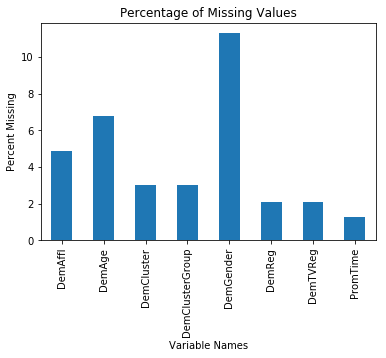

In [8]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names')

#### Impute missing values

In [20]:
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"big_organics_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"DeMAffl", "DemAge", "PromSpend", "PromTime"}},
    {"impute":{"method":"MODE"},"inputs":{"DEmCluster", "PromClass", "DeMClusterGroup", "DemGender", "DemReg", "DemTvReg"}}
  ]
)

[TransInfo]

 Transformation Requests for BIG_ORGANICS
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           4         Mean
 1       _TR2           6         Mode

[VarTransInfo]

 Variable Transformation Information for BIG_ORGANICS
 
           Variable Transformation           ResultVar       N  NMiss  \
 0          DemAffl             IM          IM_DemAffl  105690   5425   
 1           DemAge             IM           IM_DemAge  103575   7540   
 2        PromSpend             IM        IM_PromSpend  111115      0   
 3         PromTime             IM         IM_PromTime  109710   1405   
 4       DemCluster             IM       IM_DemCluster  107745   3370   
 5  DemClusterGroup             IM  IM_DemClusterGroup  107745   3370   
 6        DemGender             IM        IM_DemGender   98555  12560   
 7           DemReg             IM           IM_DemReg  108790   2325   
 8         DemTVReg             IM         IM_DemTVReg  108790   2325   
 9        PromClass             IM        IM_PromClass  111115      0   
 
    ImputedValueContinuous ImputedValueNominal  
 0                8.711893                      
 1               53.797152                      
 2             4420.590041                      
 3                6.564670                      
 4                     NaN                  52  
 5                     NaN                   C  
 6                     NaN                   F  
 7                     NaN          South East  
 8                     NaN              London  
 9                     NaN              Silver  

[NomVarInfo]

 Nominal Variable Information for BIG_ORGANICS
 
           Variable         N    NMiss  NLevels
 0       DemCluster  107745.0   3370.0     55.0
 1  DemClusterGroup  107745.0   3370.0      7.0
 2        DemGender   98555.0  12560.0      3.0
 3           DemReg  108790.0   2325.0      5.0
 4         DemTVReg  108790.0   2325.0     13.0
 5        PromClass  111115.0      0.0      4.0

[OutputCasTables]

              casLib                  Name    Rows  Columns  \
 0  CASUSER(sasdemo)  big_organics_prepped  111115       24   
 
                                             casTable  
 0  CASTable('big_organics_prepped', caslib='CASUS...  

+ Elapsed: 0.098s, user: 0.319s, sys: 0.035s, mem: 26.4mb

### Partition data into Training and Validation

In [21]:
sess.sampling.stratified(
  table={"name":"big_organics_prepped", "groupBy":"targetbuy"},
  output={"casOut":{"name":"big_organics_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=182173550 for sampling.


[outputSize]

 {'outputNObs': 111115.0, 'outputNVars': 25}

[STRAFreq]

 Frequencies
 
    ByGrpID     TargetBuy   NObs  NSamp
 0        0             0  83590  58513
 1        1             1  27525  19268

[OutputCasTables]

              casLib               Name Label    Rows  Columns  \
 0  CASUSER(sasdemo)  big_organics_part        111115       25   
 
                                             casTable  
 0  CASTable('big_organics_part', caslib='CASUSER(...  

+ Elapsed: 0.151s, user: 0.183s, sys: 0.03s, mem: 30mb

### Random Forest

In [22]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"big_organics_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="targetbuy",
  nTree=50,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  OOB=True,
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"big_organics_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"targetbuy", "_partind_"},
  vote="PROB"
)

# Create p_targetbuy0 and p_targetbuy1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_targetbuy1=_rf_predp_; 
    p_targetbuy0=1-p_targetbuy1; end; if _rf_predname_=0 then do; p_targetbuy0=_rf_predp_; p_targetbuy1=1-p_targetbuy0; end; run;"""
)

Forest for BIG_ORGANICS_PART 
 Descr 
 Value 
 
 
 Number of Trees 50 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 10 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 1481 
 Min Number of Tree Nodes 603 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 21 
 Max Number of Leaves 741 
 Min Number of Leaves 302 
 Maximum Size of Leaves 15618 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 15.619495764 
 
 
 
 
 OOB Error With Forest Analytics for BIG_ORGANICS_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 641 0.178625103 0.552179289 0.1318317436 0.3630864134 1 
 1 2 1266 0.172661989 0.4925917516 0.1269689211 0.3563269862 1 
 2 3 1833 0.1690958339 0.4603353644 0.124394112 0.3526954947 1 
 3 4 2452 0.1655255304 0.4276479006 0.122241059 0.3496298886 1 
 4 5 2813 0.1653427324 0.4078233476 0.1218506289 0.3490710943 1 
 5 6 3402 0.1637663266 0.3960169722 0.1206172165 0.3472998942 1 
 6 7 3861 0.1631492562 0.3885140664 0.1199313602 0.3463110744 1 
 7 8 4574 0.1604211232 0.3825412361 0.1185831544 0.3443590486 1 
 8 9 5196 0.1597013965 0.3791214503 0.1179469373 0.3434340363 1 
 9 10 5884 0.1581878754 0.3759799449 0.1170635811 0.3421455554 1 
 10 11 6455 0.1587860863 0.3756154023 0.117011628 0.3420696245 1 
 11 12 7074 0.1582872573 0.3747664593 0.1167047427 0.3416207585 0.9854638053 
 12 13 7815 0.1573641916 0.3730938552 0.1160351681 0.3406393519 0.9872808297 
 13 14 8400 0.1570515705 0.3729014269 0.1158687952 0.3403950575 0.9872808297 
 14 15 8702 0.1583866903 0.3745513611 0.1163842439 0.3411513505 0.9853773212 
 15 16 9196 0.1580395485 0.3746604628 0.1163293623 0.341070905 0.9812195303 
 16 17 9903 0.1577803777 0.3738134043 0.115946709 0.3405094844 0.9801909254 
 17 18 10531 0.1577763207 0.3731122173 0.1157333028 0.3401959771 0.9771208234 
 18 19 11033 0.1573134827 0.3731297273 0.115739749 0.3402054511 0.9779924378 
 19 20 11577 0.1573391959 0.3730585256 0.1157140236 0.3401676404 0.9796853272 
 20 21 12168 0.1574291922 0.3725905448 0.1155270283 0.3398926717 0.9796853272 
 21 22 12864 0.1570692071 0.371923239 0.1152730927 0.3395189135 0.976880282 
 22 23 13439 0.1568120749 0.3714835095 0.1151234981 0.3392985383 0.976880282 
 23 24 13968 0.1568377881 0.3713458814 0.1151033007 0.3392687735 0.9782022472 
 24 25 14417 0.1570306373 0.3719048202 0.1152955437 0.3395519749 0.9801838611 
 25 26 14969 0.1571977732 0.3717461708 0.1152672866 0.339510363 0.981835206 
 26 27 15585 0.1569277844 0.3713152198 0.1151110918 0.3392802556 0.981835206 
 27 28 16202 0.1572620563 0.371185165 0.1150824971 0.3392381127 0.9832324978 
 28 29 16827 0.1567863617 0.3709469253 0.1150005456 0.3391173035 0.9832324978 
 29 30 17455 0.1566963654 0.3707868616 0.1149482892 0.3390402472 0.9844301766 
 30 31 17993 0.1567220787 0.3708802759 0.114981292 0.3390889146 0.9844301766 
 31 32 18666 0.1564006634 0.3705999052 0.1148697421 0.3389243899 0.9801303618 
 32 33 19111 0.156182101 0.3708079586 0.1149308456 0.3390145212 0.9813722142 
 33 34 19694 0.1564778031 0.3708632215 0.1149853745 0.3390949343 0.9824679663 
 34 35 20332 0.1563235237 0.3706169238 0.1149194908 0.338997774 0.9824679663 
 35 36 20754 0.1561563878 0.3710317029 0.1150698416 0.3392194594 0.9824679663 
 36 37 21298 0.1558992556 0.3710829122 0.1150765599 0.3392293618 0.9834419682 
 37 38 21874 0.1560021085 0.3710495327 0.1150533231 0.3391951106 0.9834419682 
 38 39 22435 0.1559121122 0.3710786172 0.1150771584 0.339230244 0.9843134435 
 39 40 22925 0.1556935498 0.3711458762 0.1151161187 0.3392876637 0.9850977714 
 40 41 23530 0.1556164102 0.3709975934 0.1150435278 0.3391806714 0.9858074013 
 41 42 24054 0.1556806932 0.3711768476 0.1150918709 0.3392519284 0.9864525194 
 42 43 24583 0.1555135573 0.3714016164 0.1151602107 0.3393526347 0.9864525194 
 43 44 25158 0.1554621309 0.3713459469 0.1151317397 0.3393106831 0.9864525194 
 44

[OutputCasTables]

              casLib        Name    Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_rf  111115        7   
 
                                             casTable  
 0  CASTable('_scored_rf', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                            111115
 1  Number of Observations Used                            111115
 2  Misclassification Error (%)                      15.060972866

+ Elapsed: 1.99s, user: 11.6s, sys: 0.113s, mem: 385mb

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:127
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:127  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_rf,111115,7,"CASTable('_scored_rf', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_rf,111115,9,"CASTable('_scored_rf', caslib='CASUSER(sasdemo)')"


### Gradient Boosting

In [23]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"big_organics_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="targetbuy",
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"big_organics_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"targetbuy", "_partind_"}
)

# Create p_targetbuy0 and p_targetbuy1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_targetbuy1=_gbt_predp_; 
    p_targetbuy0=1-p_targetbuy1; end; if _gbt_predname_=0 then do; p_targetbuy0=_gbt_predp_; p_targetbuy1=1-p_targetbuy0; end; run;"""
)

Gradient Boosting Tree for BIG_ORGANICS_PART 
 Descr 
 Value 
 
 
 Number of Trees 10 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 10 
 Number of Bins 20 
 Number of Variables 10 
 Max Number of Tree Nodes 63 
 Min Number of Tree Nodes 63 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 32 
 Min Number of Leaves 32 
 Maximum Size of Leaves 6740 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for BIG_ORGANICS_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 DemAge 1128.4910494 544.29844804 
 DemAffl 795.11264054 142.1618696 
 DemGender 463.24409047 83.909609435 
 DemCluster 286.7660408 11.856049554 
 DemTVReg 4.7672511202 4.6420634417 
 PromTime 1.1977421958 1.5976673537 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(sasdemo) gb_model 630 112 CASTable('gb_model', caslib='CASUSER(sasdemo)')

[OutputCasTables]

              casLib        Name    Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_gb  111115        6   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                            111115
 1  Number of Observations Used                            111115
 2  Misclassification Error (%)                      18.512352068

[ErrorMetricInfo]

    TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0     0.0    1.0     32.0  0.247716  0.532874  0.175904  0.419410  0.773444
 1     1.0    2.0     64.0  0.247716  0.512238  0.167485  0.409250  0.793518
 2     2.0    3.0     96.0  0.247716  0.496016  0.160777  0.400970  0.810938
 3     3.0    4.0    128.0  0.247041  0.482532  0.155193  0.393945  0.827625
 4     4.0    5.0    160.0  0.223237  0.471190  0.150523  0.387973  0.841142
 5     5.0    6.0    192.0  0.209063  0.461312  0.146527  0.382789  0.854662
 6     6.0    7.0    224.0  0.201638  0.453264  0.143361  0.378630  0.867177
 7     7.0    8.0    256.0  0.193223  0.446033  0.140595  0.374960  0.877874
 8     8.0    9.0    288.0  0.189173  0.439973  0.138344  0.371946  0.887378
 9     9.0   10.0    320.0  0.185124  0.434817  0.136443  0.369382  0.895889

+ Elapsed: 0.183s, user: 0.943s, sys: 0.012s, mem: 15.1mb

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:129
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:129  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_gb,111115,6,"CASTable('_scored_gb', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_gb,111115,8,"CASTable('_scored_gb', caslib='CASUSER(sasdemo)')"


### Neural Network

In [24]:
nn = sess.neuralNet.annTrain(
  table={
    "name":"big_organics_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"big_organics_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="targetbuy",
  hiddens={1},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Output model statistics
render_html(nn)

# Score 
sess.neuralNet.annScore(
  table={"name":"big_organics_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"targetbuy", "_partind_"}
)

# Create p_targetbuy0 and p_targetbuy1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="""data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_targetbuy1=_nn_predp_; 
    p_targetbuy0=1-p_targetbuy1; end; if _nn_predname_=0 then do; p_targetbuy0=_nn_predp_; p_targetbuy1=1-p_targetbuy0; end; run;"""
)

Iteration History 
 Progress 
 Objective 
 Loss 
 Validation Error 
 Step Size 
 L1 Norm 
 L2 Norm 
 MAX Norm 
 Gradient Norm 
 
 
 1 2.7770563134 2.7770563134 0.5899525605 0 1.2346401345 0.7177936312 0.7150174475 1.6850466322 
 2 2.3188252362 2.3188252362 0.2615253619 0.5934553863 4.2550415254 1.0123344743 0.7112453309 0.205476759 
 3 2.3044532607 2.3044532607 0.2615253619 1 4.1140584688 0.9566624816 0.6467537445 0.0802230954 
 4 2.3000656235 2.3000656235 0.2615253619 1 3.9971317105 0.9279032357 0.6202659485 0.0689011378 
 5 2.2827246963 2.2827246963 0.2615253619 2.8869896204 3.7536886129 0.9218361844 0.592547449 0.333965067 
 6 2.2795072199 2.2795072199 0.2615253619 0.0594757619 3.7980414079 0.9392311037 0.5935944295 0.3812517671 
 7 2.2660510562 2.2660510562 0.2615253619 0.3620096603 3.964834231 1.0135622895 0.6137949339 0.4724934202 
 8 2.2506205964 2.2506205964 0.2231277622 1 4.8309444134 1.3495550294 0.7243377502 0.7658958961 
 9 2.1763709454 2.1763709454 0.2431577667 1 4.9041359896 1.351375599 0.7552770104 0.5101025261 
 10 2.0372082803 2.0372082803 0.2421035559 1 6.343332994 1.7984066077 1.0238499208 0.2150778131 
 11 1.9811508503 1.9811508503 0.2185460001 1 7.99008452 2.3218335201 1.278358238 0.1360494532 
 12 1.9261775208 1.9261775208 0.2029761181 1 8.6101526982 2.6888381635 1.5712791361 0.1665290542 
 13 1.8623684144 1.8623684144 0.1977456108 0.4877867818 9.5244315509 3.2902304308 2.0279189377 0.2582913137 
 14 1.8463073684 1.8463073684 0.1975023314 1 10.581880506 3.6233617645 2.2083028742 0.3334497619 
 15 1.8249867859 1.8249867859 0.1944207923 1 9.6980727457 3.3724925387 2.0698791014 0.0979896009 
 16 1.8197686655 1.8197686655 0.1949478977 1 9.5308554297 3.321423466 2.0337211936 0.0893326322 
 17 1.8035877329 1.8035877329 0.1950289908 1 10.280826094 3.51127962 2.245414752 0.0984130112 
 18 1.7982699381 1.7982699381 0.1965292138 1 10.851949302 3.6452197575 2.4600879819 0.1107640518 
 19 1.7924813957 1.7924813957 0.1962453878 1 11.522843146 3.8625934789 2.6135262261 0.0670980264 
 20 1.7915908029 1.7915908029 0.194826258 1 11.219358944 3.7732729189 2.5243923074 0.0280893804 
 21 1.7911640936 1.7911640936 0.1950695374 1 11.217746244 3.7627740971 2.5154914845 0.0229194795 
 22 1.7906956897 1.7906956897 0.194826258 1 11.215900856 3.7422967497 2.4958365216 0.0295205826 
 23 1.7897535576 1.7897535576 0.1951100839 1 11.33857769 3.742437882 2.4705058825 0.0489800618 
 24 1.7885995737 1.7885995737 0.1960021084 1 11.630849341 3.6921763416 2.3851866463 0.0329261311 
 25 1.7877724497 1.7877724497 0.1961237481 1 12.026521836 3.752110176 2.4547809724 0.0392914165 
 26 1.7869073878 1.7869073878 0.1952722702 1 12.185449631 3.7435449404 2.4957789818 0.0324614421 
 27 1.7862560096 1.7862560096 0.1950695374 1 12.315060376 3.7129857531 2.5238527505 0.0257796487 
 28 1.7856304231 1.7856304231 0.1960832016 1 12.405853478 3.693422955 2.5494950224 0.0309694558 
 29 1.7849184279 1.7849184279 0.1975023314 1 12.543883228 3.6707298737 2.5844398252 0.0245105529 
 30 1.7843908463 1.7843908463 0.1964075741 1 12.647140126 3.6763546297 2.6167264579 0.0223116583 
 31 1.7840948708 1.7840948708 0.1971374123 1 12.578910686 3.6720659569 2.6273812292 0.0295932532 
 32 1.7838621117 1.7838621117 0.1971374123 1 12.47422979 3.668173847 2.6285442497 0.018331926 
 33 1.7834800596 1.7834800596 0.1958399222 1 12.333179695 3.6497690395 2.6441292224 0.0188656671 
 34 1.7829924768 1.7829924768 0.1955560962 1 12.248591068 3.6344448334 2.680750733 0.0185412576 
 35 1.7819753165 1.7819753165 0.1965697604 1 12.054710166 3.6227733062 2.8029484965 0.0383146321 
 36 1.7817027395 1.7817027395 0.1976645177 0.3093146626 12.01400673 3.6323407505 2.8433444485 0.0294551548 
 37 1.7814016321 1.7814016321 0.197259052 1 12.026076679 3.6472584104 2.8763351164 0.0171097355 
 38 1.7811909989 1.7811909989 0.1968130398 1 12.014127366 3.6596911717 2.8908618836 0.0166520616 
 39 1.780988257 1.780988257 0.1971374123 0.3753202584 11.955219036 3.6858520947 2.9302036137 0.0333073664 
 40 1.

[OutputCasTables]

              casLib        Name    Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_nn  111115        4   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                            111115
 1  Number of Observations Used                             82040
 2  Misclassification Error (%)                      19.569722087

+ Elapsed: 0.0649s, user: 0.306s, sys: 0.008s, mem: 12.8mb

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:127
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:127  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_nn,111115,4,"CASTable('_scored_nn', caslib='CASUSER(sasdemo)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),_scored_nn,111115,6,"CASTable('_scored_nn', caslib='CASUSER(sasdemo)')"


### Assess Models

In [29]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_targetbuy1"}],      
      response="targetbuy",
      event="1",
      pVar={"p_targetbuy0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

nn_rocinfo

,Variable,Event,CutOff,TP,FP,FN,TN,Sensitivity,Specificity,KS,KS2,F_HALF,FPR,ACC,FDR,F1,C,Gini,Gamma,Tau
0,p_targetbuy1,1,0.00,6450.0,18213.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.306845,1.000000,0.261525,0.738475,0.414618,0.806714,0.613428,0.620944,0.236952
1,p_targetbuy1,1,0.01,6450.0,18213.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.306845,1.000000,0.261525,0.738475,0.414618,0.806714,0.613428,0.620944,0.236952
2,p_targetbuy1,1,0.02,6450.0,18213.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.306845,1.000000,0.261525,0.738475,0.414618,0.806714,0.613428,0.620944,0.236952
3,p_targetbuy1,1,0.03,6450.0,18084.0,0.0,129.0,1.000000,0.007083,0.0,0.007083,0.308359,0.992917,0.266756,0.737100,0.416344,0.806714,0.613428,0.620944,0.236952
4,p_targetbuy1,1,0.04,6444.0,17516.0,6.0,697.0,0.999070,0.038269,0.0,0.037339,0.314987,0.961731,0.289543,0.731052,0.423808,0.806714,0.613428,0.620944,0.236952
5,p_targetbuy1,1,0.05,6413.0,16680.0,37.0,1533.0,0.994264,0.084171,0.0,0.078434,0.324472,0.915829,0.322183,0.722297,0.434147,0.806714,0.613428,0.620944,0.236952
6,p_targetbuy1,1,0.06,6353.0,15756.0,97.0,2457.0,0.984961,0.134904,0.0,0.119865,0.334770,0.865096,0.357215,0.712651,0.444904,0.806714,0.613428,0.620944,0.236952
7,p_targetbuy1,1,0.07,6280.0,14833.0,170.0,3380.0,0.973643,0.185582,0.0,0.159225,0.345427,0.814418,0.391680,0.702553,0.455683,0.806714,0.613428,0.620944,0.236952
8,p_targetbuy1,1,0.08,6220.0,13848.0,230.0,4365.0,0.964341,0.239664,0.0,0.204005,0.358617,0.760336,0.429185,0.690054,0.469115,0.806714,0.613428,0.620944,0.236952
9,p_targetbuy1,1,0.09,6136.0,12942.0,314.0,5271.0,0.951318,0.289409,0.0,0.240726,0.370702,0.710591,0.462515,0.678373,0.480727,0.806714,0.613428,0.620944,0.236952


### Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [30]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(nn_liftinfo, ignore_index=True)  
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(nn_rocinfo, ignore_index=True) 

#### Print AUC (Area Under the ROC Curve)

In [31]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.871039
100,GradientBoosting,0.834753
200,NeuralNetwork,0.806714


#### Draw ROC and Lift plots

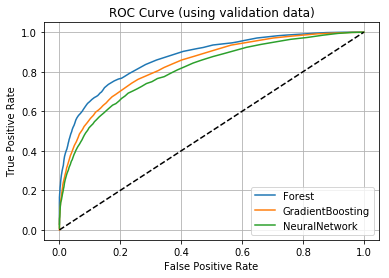

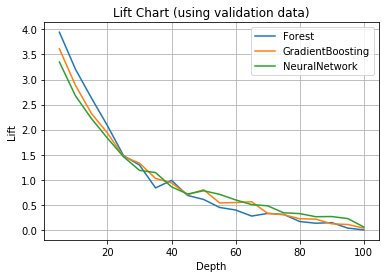

In [32]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [33]:
sess.close()